# Ejercicio 1:
El set de datos 1 contiene información respecto a los estudiantes que han ingresado a la facultad de ingeniería. Se le pide que implemente una regresión logística que permita aprender a clasificar a que clúster pertenece cada alumno de acuerdo la información que se entrega. Recuerde que por convención la última columna del set de datos representa la señal que usted quiere aprender. También tenga en cuenta que las clases están desbalanceadas y que se espera que usted utilice 80% de los datos para entrenar y el 20% restante para testear. Además, presente una matriz de confusión y el f1-score. Finalmente, una restricción fuerte de este ejercicio es que todo debe estar programado en Tensorflow 2 y desarrollado en Colab.

## Preparación del codigo
En esta primera celda, cargaremos las bibliotecas necesarias para correr el codigo.

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import logging
os.environ['TF_CPP_MIN_VLOG_LEVEL'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.getLogger("tensorflow").setLevel(logging.WARNING)

import math
import statistics as stats

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import tensorflow as tf
from tensorflow import keras
print (tf.__version__)
tf.get_logger().setLevel("ERROR")
tf.autograph.set_verbosity(2)

2.2.0


A continuación, cargaremos nuestro conjunto de datos de un repositorio de github.

In [ ]:
datos1 = pd.read_excel("https://raw.githubusercontent.com/BastiCaa/prueba/master/dataset1.xlsx")
print (datos1[['Longitud']])

      Longitud
0    -73.16487
1    -73.16487
2    -73.16487
3    -73.16487
4    -73.16487
...        ...
7861 -73.01875
7862 -73.01875
7863 -73.01875
7864 -73.01875
7865 -73.01875

[7866 rows x 1 columns]


## Análisis de los datos
Familiarización de los datos imprimiendo la estadistica descriptiva de los mismos.

In [ ]:
datos1.head()
datos1.describe()

,psu_Nem,psu_Leng,psu_Mate,psu_Cie,psu_Pond,Longitud,Latitud,cred_apr,distancia,F,M,PARTICULAR_SUBVENCIONADO,PARTICULAR_PAGADO,MUNICIPAL
count,7866.000000,7866.000000,7866.000000,7866.000000,7866.000000,7866.000000,7866.000000,7866.000000,7866.000000,7866.000000,7866.000000,7866.000000,7866.000000,7866.000000
mean,668.634630,618.109586,669.857107,622.594839,659.579456,-72.846972,-36.899123,18.208874,33.065784,0.220061,0.779939,0.521103,0.241927,0.236969
std,71.116963,65.337494,56.908442,60.070238,48.014462,0.404343,0.282372,14.321758,39.204470,0.414314,0.414314,0.499586,0.428278,0.425250
min,373.000000,322.000000,494.000000,322.000000,512.000000,-73.649141,-38.016235,0.000000,0.415859,0.000000,0.000000,0.000000,0.000000,0.000000
25%,620.000000,574.000000,630.000000,585.000000,626.000000,-73.097558,-36.902500,0.000000,2.273443,0.000000,1.000000,0.000000,0.000000,0.000000
50%,678.000000,616.000000,666.000000,623.000000,657.000000,-73.046415,-36.828456,21.000000,8.198763,0.000000,1.000000,1.000000,0.000000,0.000000
75%,723.000000,660.000000,702.000000,661.000000,692.000000,-72.541530,-36.778573,33.000000,85.512871,0.000000,1.000000,1.000000,0.000000,0.000000
max,826.000000,831.000000,850.000000,850.000000,825.000000,-71.549363,-36.132387,40.000000,136.283837,1.000000,1.000000,1.000000,1.000000,1.000000


## Pre-procesamiento de los datos
Como dentro de la base de datos nos encontramos con datos tipos string, es necesario hacerles un one hot encoding a los datos de estas columnas. De esta manera podremos trabajar con ellos de la forma en que se desea. Además, se definieron las entradas y salida de los datos, junto con la división del 80% de los datos para entrenar y el 20% restante para testear. Por último, se escalaron los datos, ya que las caracteristicas de los mismos son completamente distintas en magnitudes, unidades y rango, para asi llevarlos a un mismo nivel de magnitudes.

In [ ]:
crr_Nom_dummy = pd.get_dummies(datos1["crr_Nom"], prefix="crr_Nom")
cluster_dummy = pd.get_dummies(datos1["cluster"], prefix="cluster")

datos1 = pd.concat([datos1, crr_Nom_dummy], axis = 1)
datos1 = pd.concat([datos1, cluster_dummy], axis = 1)

datos1_dummies = datos1.drop(['crr_Nom', 'cluster'], axis = 1)

# Inputs
X = datos1_dummies.iloc[:,0:27].values

# Target
y = datos1_dummies.iloc[:,28:32].values

# Division de la data de entrenamiento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)#0.2

# Escalación de los datos
escalar = StandardScaler()
X_train = escalar.fit_transform(X_train)

X_test = escalar.transform(X_test)

## Definición de funciones

En esta parte se definen las funciones necesarias que requiere el modelo para el entrenamiento de la red neuronal armada en Model(object). La funcion de activación que se utlizo en la primera capa fue la sigmoid y en la segunda capa fue la softmax, ya que esta es la empleada en métodos de clasificación multiclase. También, se utilizó la función de divergencia crossentropy junto con la regularización L1 para calcular el error del modelo. Por ultimo, para la optimizacion del modelo, se uso el GradientTape.

In [ ]:
class Model (object):
    def __init__(self):
        samples, features = (6292,27) #x.shape
        hidden1_nodes = 27
        hidden2_nodes = 4
        self.theta1 = tf.Variable(tf.random.normal([features+1,hidden1_nodes], dtype= tf.float64) ,name = "Theta1")
        self.theta2 = tf.Variable(tf.random.normal([hidden1_nodes+1,hidden2_nodes], dtype= tf.float64), name = "Theta2")
    
    def __call__(self, X_train): # Son metodos que vienen predifinidos desde el object.
        bias1 = tf.constant(1, shape=(6292,1), dtype=tf.float64, name='bias1')
        bias2 = tf.constant(1, shape=(6292,1), dtype=tf.float64, name='bias2')
        a0 = tf.concat([bias1,X_train],1, name='a0')
        z1 = tf.matmul(a0,self.theta1, name='z1') 
        a1 = tf.concat([bias2,tf.sigmoid(z1)],1,name='a1')
        z2 = tf.matmul(a1,self.theta2, name='z2')
        a2 = tf.nn.softmax(z2, name='a2')
        return a2 # Respuesta, aqui ya predice


def loss(target_y, predicted_y): # Funcion de divergencia.
    losses = tf.keras.losses.categorical_crossentropy(target_y,predicted_y) #entrega un array de longitud mayor a 1
    regulacion = 0.001*tf.reduce_sum(tf.abs(target_y - predicted_y)) 
    losses_1 = tf.reduce_mean(losses) + regulacion  #entrega el promedio del array losses el cual es de una dimension, esto para evitar el lenght-1
    return losses_1, regulacion

def train(model, inputs, outputs, learning_rate): # Recibe todo, para entrenar el modelo.
    with tf.GradientTape() as t:
        current_loss =loss(outputs, model(inputs)) # El model con el call sabe predecir
    dThe1, dThe2 = t.gradient(current_loss[0], [model.theta1, model.theta2])
    model.theta1.assign_sub(learning_rate * dThe1)
    model.theta2.assign_sub(learning_rate * dThe2)
    
def lr_schedule(epoch):
    learning_rate = 0.5
    if epoch > 5000:
        learning_rate = 0.4
    if epoch > 7000:
        learning_rate = 0.2
    #if epoch > 10000:
        #learning_rate = 0.05
    return learning_rate

def matriz(y_predicho, y_test):
    y_test_prec = np.argmax(y_predicho,axis=1)#Se transforma el vector Encode a uno con la posicion del mayor elemento.
    y_compro = np.argmax(y_test,axis=1)
    matriz = confusion_matrix(y_compro, y_test_prec)#Se crea la matriz de confusion de dimension (4,4) para los 4 cluster disponibles
    print(matriz)
    return matriz

def evaluar(X_test, y_test, theta1_t, theta2_t, batch_size): #Se toman los thetas obtenidos en el entrenamiento y ocupan para predecir la muestra a testear
    bias1_t = tf.constant(1, shape=(1574,1), dtype=tf.float64, name='bias1')
    bias2_t = tf.constant(1, shape=(1574,1), dtype=tf.float64, name='bias2')
    a0_t = tf.concat([bias1_t, X_test],1, name='a0_t')
    z1_t = tf.matmul(a0_t, theta1_t, name='z1_t') 
    a1_t = tf.concat([bias2_t, tf.sigmoid(z1_t)],1, name='a1_t')
    z2_t = tf.matmul(a1_t, theta2_t, name='z2_t')
    a2_t = tf.nn.softmax(z2_t, name='a2_t')
    return a2_t

## Entrenamiento del modelo
Ahora podemos llamar a las funciones para entrenar el modelo. Entrenaremos el modelo en un rango 10000 epoch.

In [ ]:
model = Model() # Voy ajustando mis thetas en el proceso de aprendizaje
theta1_hist, theta2_hist = [] , []
for epoch in range(10000):
    learning_rate = lr_schedule(epoch)
    current_loss = loss(y_train, model(X_train))
    train(model, X_train, y_train, learning_rate=learning_rate)
    if epoch % 1000 == 0:
        theta1_hist.append(model.theta1.numpy())
        theta2_hist.append(model.theta2.numpy())
        print('Epoch %2d: learning_rate=%2.5f, loss=%2.5f , regulacion=%2.5f' % (epoch, learning_rate, current_loss[0],current_loss[1]))

Epoch  0: learning_rate=0.50000, loss=12.17201 , regulacion=9.55484
Epoch 1000: learning_rate=0.50000, loss=1.89649 , regulacion=1.55185
Epoch 2000: learning_rate=0.50000, loss=1.51200 , regulacion=1.20855
Epoch 3000: learning_rate=0.50000, loss=1.31306 , regulacion=1.02116
Epoch 4000: learning_rate=0.50000, loss=1.21432 , regulacion=0.92096
Epoch 5000: learning_rate=0.50000, loss=1.14577 , regulacion=0.85033
Epoch 6000: learning_rate=0.40000, loss=1.10081 , regulacion=0.80710
Epoch 7000: learning_rate=0.40000, loss=1.06436 , regulacion=0.77267
Epoch 8000: learning_rate=0.20000, loss=1.05040 , regulacion=0.75914
Epoch 9000: learning_rate=0.20000, loss=1.03816 , regulacion=0.74742


## Evaluación del modelo
Finalmente, se realizaron predicciones sobre los datos de entrenamiento para ver qué tan bien los ajustó nuestro modelo durante el entrenamiento. Junto a esto, se midió qué tan bien el modelo realiza generalizaciones con respecto a los datos nuevos. Y ademas, se calcularon las metricas respectivas para verificar el rendimiento y precisión del modelo. Presentando una matriz de confusión y el f1-score.

In [ ]:
#Evaluacion de datos
theta1_t = model.theta1
theta2_t = model.theta2
batch_size = 1574

#Testea con funcion evaluar
testeo = evaluar(X_test,y_test,theta1_t,theta2_t,batch_size)

#Creacion de matrices
X_entrenado = model(X_train)

#Matriz de confusion de muestras entrenadas
print('Matriz de confusion de muestras entrenadas')
matriz_train = matriz(X_entrenado,y_train)

#Matriz de confusion de muestras de testeo
print('Matriz de confusion de muestras de testeo')
matriz_testeo = matriz(testeo,y_test)

#Prueba F1-score
y_true = np.argmax(y_train, axis=1)
y_predicho = np.argmax(model(X_train),axis=1)
y_testeo = np.argmax(testeo, axis=1)
y_test1 = np.argmax(y_test, axis=1)
significancia_train = f1_score(y_true, y_predicho, average=None)
significancia_test = f1_score(y_test1, y_testeo, average=None)
mean_train=stats.mean(significancia_train)
mean_test=stats.mean(significancia_test)
print('Precision entrenamiento por Cluster: C1=%2.5f C2=%2.5f C3=%2.5f C4=%2.5f'% (significancia_train[0],significancia_train[1],significancia_train[2],significancia_train[3]))
print('Precision testeo por Cluster: C1=%2.5f C2=%2.5f C3=%2.5f C4=%2.5f'% (significancia_test[0],significancia_test[1],significancia_test[2],significancia_test[3]))
print('Precision promedio de entrenamiento: %2.5f' % mean_train)
print('Precision promedio de testeo: %2.5f' % mean_test)

Matriz de confusion de muestras entrenadas
[[1021   55    1    0]
 [  25 2811   52   10]
 [   0   33 1350   32]
 [   0    8   35  859]]
Matriz de confusion de muestras de testeo
[[216  39   0   0]
 [ 28 655  42   8]
 [  0  35 294  29]
 [  0  20  16 192]]
Precision entrenamiento por Cluster: C1=0.96185 C2=0.96848 C3=0.94637 C4=0.95286
Precision testeo por Cluster: C1=0.86573 C2=0.88394 C3=0.82817 C4=0.84026
Precision promedio de entrenamiento: 0.95739
Precision promedio de testeo: 0.85453


# Ejercicio 2:
El set de datos 2 contiene información respecto a zonas de exclusión de pesca en las costas de la octava región. Se le solicita a usted desarrollar un modelo de clasificación con el cual poder predecir si un barco se encuentra o no en la zona de exclusión. Nuevamente considere que las clases están desbalanceadas y que se espera que usted utilice 80% de los datos para entrenar y el 20% restante para testear. Además, presente una matriz de confusión y el f1-score. Finalmente, una restricción fuerte de este ejercicio es que todo debe estar programado en Tensorflow 2 y desarrollado el mismo Colab notebook.

## Preparación del codigo
Para este problema se usaran las mismas bibliotecas cargadas en el ejercicio 1 para correr el codigo. A continuación, cargaremos nuestro conjunto de datos de un drive.

In [ ]:
from google.colab import auth
auth.authenticate_user()

from pydrive.drive import GoogleDrive
from pydrive.auth import GoogleAuth
from oauth2client.client import GoogleCredentials
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

myfile = drive.CreateFile({'id': '1ZLZA1oNBgVVN6hBwkW0eLUd4gCluCucL'})
myfile.GetContentFile('dataset2.csv')

datos2 = pd.read_csv("dataset2.csv", sep=",")
print(datos2.describe())

## Pre-procesamiento de los datos
Lo primero que se realizo fue pasar los datos 'y' y 'condition' a float64, ya que se encontraban en int64. Además, se definieron las entradas y salida de los datos, junto con la división del 80% de los datos para entrenar y el 20% restante para testear. Por último, se escalaron los datos, ya que las caracteristicas de los mismos son completamente distintas en magnitudes, unidades y rango, para asi llevarlos a un mismo nivel de magnitudes.

In [ ]:
# Pasando de int64 a float64
datos2['y'] = datos2.y.astype(float)
datos2['condition'] = datos2.condition.astype(float)

# Declare the inputs
x2 = datos2.drop('condition', axis=1).values

# Target
y2 = datos2[['condition']].values


# Division de la data de entrenamiento
x_train21, x_test21, y_train2, y_test2 = train_test_split(x2, y2, test_size=0.2)

# Escalar los datos
escalar2 = StandardScaler()
x_train2 = escalar2.fit_transform(x_train21)
x_test2 = escalar2.transform(x_test21)
print(tf.shape(x_train2))
print(tf.shape(y_train2))

tf.Tensor([65317     2], shape=(2,), dtype=int32)
tf.Tensor([65317     1], shape=(2,), dtype=int32)


## Definición de funciones

En esta parte se definen las funciones necesarias que requiere el modelo para el entrenamiento de la red neuronal armada en Model(object). La función de activacion que se utilizo fue la sigmoid en las 3 capas. También, se utilizó la función de divergencia de Logistic Regression junto con la regularización L1 para calcular el error del modelo. Por ultimo, para la optimizacion del modelo, se uso el GradientTape.

In [ ]:
class Model2(object):
    def __init__(self):
        samples2, features2 = (81647,2) #x.shape
        hidden1_nodes2 = 9
        hidden2_nodes2 = 2
        hidden3_nodes2 = 1
        self.theta12 = tf.Variable(tf.random.normal([features2+1,hidden1_nodes2], dtype= tf.float64) ,name = "Theta12")
        self.theta22 = tf.Variable(tf.random.normal([hidden1_nodes2+1,hidden2_nodes2], dtype= tf.float64), name = "Theta22")
        self.theta32 = tf.Variable(tf.random.normal([hidden2_nodes2+1,hidden3_nodes2], dtype= tf.float64), name = "Theta32")

    def __call__(self, x_train2): # Son metodos que vienen predifinidos desde el object.
        bias12 = tf.constant(1, shape=(65317,1), dtype=tf.float64, name='bias12')
        bias22 = tf.constant(1, shape=(65317,1), dtype=tf.float64, name='bias22')
        bias32 = tf.constant(1, shape=(65317,1), dtype=tf.float64, name='bias32')
        a02 = tf.concat([bias12,x_train2],1, name='a0')
        z12 = tf.matmul(a02,self.theta12, name='z12') # [4x2]
        a12 = tf.concat([bias22,tf.sigmoid(z12)],1,name='a12')
        z22 = tf.matmul(a12,self.theta22, name='z22')
        a22 = tf.concat([bias32,tf.sigmoid(z22)],1,name="a22")
        z32 = tf.matmul(a22,self.theta32, name="z32")
        a32 = tf.sigmoid(z32, name='a32')
        return a32 # Respuesta, aqui ya predice

def loss2(target_y2, predicted_y2): # Funcion de divergencia, Aqui esta la funcion Logistic_regression
        regularizacion2=1*tf.reduce_sum(tf.abs(target_y2 - predicted_y2)) 
        losses2=-tf.reduce_sum(target_y2*tf.math.log(predicted_y2)+(1-target_y2)*tf.math.log(1-predicted_y2),axis=0, name='Cost_function') +regularizacion2
        return losses2,regularizacion2

def train2(model2, inputs2, outputs2, learning_rate2): # Recibe todo, para entrenar el modelo.
    with tf.GradientTape() as t2:
        current_loss2 = loss2(outputs2, model2(inputs2)) # El model con el call sabe predecir
    dThe12, dThe22, dThe32 = t2.gradient(current_loss2[0], [model2.theta12, model2.theta22, model2.theta32])
    model2.theta12.assign_sub(learning_rate2 * dThe12)
    model2.theta22.assign_sub(learning_rate2 * dThe22)
    model2.theta32.assign_sub(learning_rate2 * dThe32)
    
def lr_schedule2(epoch2):# se usan rates del orden de 0,0000 porque con rates mayores diverge el problema y entrega loss=Nan
    learning_rate2 = 0.0002
    if epoch2 > 1500:
        learning_rate2 = 0.00009
    if epoch2 > 1900:
        learning_rate2 = 0.00006
    if epoch2 > 3300:
        learning_rate2 = 0.00005
    if epoch2 > 4800:
        learning_rate2 = 0.00002
    return learning_rate2

def matriz2(y_predicho2,y_test2):
    matriz2 = confusion_matrix(y_predicho2, y_test2)
    print(matriz2)
    return matriz2

def evaluar2(X_test2, y_test2, theta1_t2, theta2_t2, theta3_t2, batch_size2):
    bias1_t2 = tf.constant(1, shape=(16330,1), dtype=tf.float64, name='bias1_t2')#6292
    bias2_t2 = tf.constant(1, shape=(16330,1), dtype=tf.float64, name='bias2_t2')
    bias3_t2 = tf.constant(1, shape=(16330,1), dtype=tf.float64, name='bias3_t2')
    a0_t2 = tf.concat([bias1_t2, X_test2],1, name='a0_t2')
    z1_t2 = tf.matmul(a0_t2,theta1_t2, name='z1_t2') 
    a1_t2 = tf.concat([bias2_t2, tf.sigmoid(z1_t2)],1,name='a1_t2')
    z2_t2 = tf.matmul(a1_t2,theta2_t2, name='z2_t2')
    a2_t2 = tf.concat([bias3_t2, tf.sigmoid(z2_t2)],1, name='a2_t2')
    z3_t2 = tf.matmul(a2_t2,theta3_t2, name='z3_t2')
    a3_t2 = tf.sigmoid(z3_t2, name='a3_t2')
    return a3_t2


## Entrenamiento del modelo
Ahora podemos llamar a las funciones para entrenar el modelo. Entrenaremos el modelo en un rango de 8000 epoch.

In [ ]:
model2 = Model2() # Voy ajustando mis tetas en el proceso de aprendizaje
theta1_hist2, theta2_hist2, theta3_hist2= [], [], []
for epoch2 in range(8000):
    current_loss2 = loss2(y_train2, model2(x_train2))
    learning_rate2 = lr_schedule2(epoch2)
    train2(model2, x_train2,y_train2, learning_rate2=learning_rate2)
    if epoch2 % 500== 0:
        theta1_hist2.append(model2.theta12.numpy())
        theta2_hist2.append(model2.theta22.numpy())
        theta3_hist2.append(model2.theta32.numpy())
        print('Epoch %2d: learning_rate=%2.5f, loss=%2.5f , regulacion=%2.5f' % (epoch2, learning_rate2, current_loss2[0],current_loss2[1]))

Epoch  0: learning_rate=0.00020, loss=132861.93926 , regulacion=44772.41507
Epoch 500: learning_rate=0.00020, loss=30158.99787 , regulacion=10123.22119
Epoch 1000: learning_rate=0.00020, loss=20232.12432 , regulacion=7330.09148
Epoch 1500: learning_rate=0.00020, loss=12836.40055 , regulacion=3875.89781
Epoch 2000: learning_rate=0.00006, loss=4993.84952 , regulacion=1748.79866
Epoch 2500: learning_rate=0.00006, loss=4605.27360 , regulacion=1586.24974
Epoch 3000: learning_rate=0.00006, loss=4326.33457 , regulacion=1491.41049
Epoch 3500: learning_rate=0.00005, loss=3944.39111 , regulacion=1403.83763
Epoch 4000: learning_rate=0.00005, loss=3456.41407 , regulacion=1280.48089
Epoch 4500: learning_rate=0.00005, loss=3127.63997 , regulacion=1179.19854
Epoch 5000: learning_rate=0.00002, loss=2988.95819 , regulacion=1128.03733
Epoch 5500: learning_rate=0.00002, loss=2906.33217 , regulacion=1101.35408
Epoch 6000: learning_rate=0.00002, loss=2834.86114 , regulacion=1076.76992
Epoch 6500: learning_

## Evaluación del modelo
Finalmente, se realizaron predicciones sobre los datos de entrenamiento para ver qué tan bien los ajustó nuestro modelo durante el entrenamiento. Junto a esto, se midió qué tan bien el modelo realiza generalizaciones con respecto a los datos nuevos. Luego, obtenido la función de perdida, se redondearon los resultados de los datos pronosticados para poder calcular las metricas respectivas de rendimiento y precisión. La matriz de confusión y el f1-score. 

In [ ]:
##Evaluacion de datos
theta1_t2 = model2.theta12
theta2_t2 = model2.theta22
theta3_t2 = model2.theta32
batch_size2 = 16330

#testea con funcion evaluar y redondeo de resultados para evaluar su rendimiento
testeo2 = np.round(evaluar2(x_test2,y_test2,theta1_t2,theta2_t2,theta3_t2,batch_size2))
X_entrenado2 = np.round(model2(x_train2))

#matriz de confusion de entrenamiento
print('matriz de confusion de entrenamiento')
matriz_train2 = matriz2(X_entrenado2,y_train2)

#matriz de confusion de testeo
print('matriz de confusion de testeo')
matriz_testeo2 = matriz2(testeo2,y_test2)

#prueba F1-score
significancia_train2 = f1_score(y_train2, X_entrenado2)
significancia_testeo2 = f1_score(y_test2, testeo2)
print('Precision de entrenamiento= %2.5f'%(significancia_train2))
print('Precision de test= %2.5f'% (significancia_testeo2))

matriz de confusion de entrenamiento
[[52311   409]
 [  242 12355]]
matriz de confusion de testeo
[[12972   105]
 [   61  3192]]
Precision de entrenamiento= 0.97433
Precision de test= 0.97466


## Grafico de puntos de referencia
A modo de análisis. se grafican los puntos mal clasificados por el modelo, para así poder visualizar las zonas de conflicto en donde los puntos se clasifican erroneamente. Se puede apreciar que la perdida observada del modelo (loss)  se encuentra mayoritariamente  en los puntos cercanos a las fronteras de las zonas de exclusión de pesca.

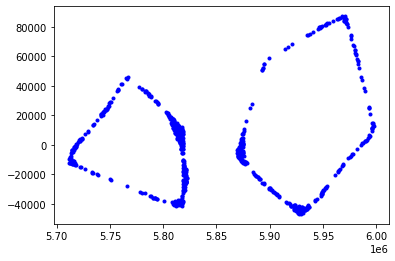

In [ ]:
malo_x_train,malo_y_train=[],[]
for n in range(0,65317):
  if X_entrenado2[n]!=y_train2[n]:
      malo_x_train.append(x_train21[n,0])
      malo_y_train.append(x_train21[n,1])
plt.plot(malo_y_train,malo_x_train,'b.')
plt.show()

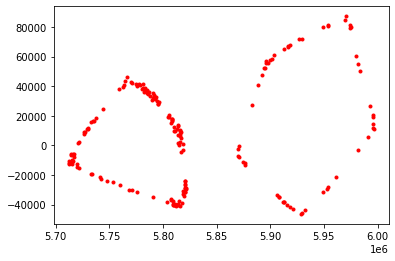

In [ ]:
malo_x_test,malo_y_test=[],[]
for n in range(0,16330):
  if testeo2[n]!=y_test2[n]:
      malo_x_test.append(x_test21[n,0])
      malo_y_test.append(x_test21[n,1])
plt.plot(malo_y_test,malo_x_test,'r.')
plt.show()